In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import kagglehub
import psycopg2 as pg2
import os

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# ignore warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.makedirs('output', exist_ok=True)

In [3]:

# Download do dataset
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")

# Listar arquivos disponíveis
files = os.listdir(path)

olist_data = {}
for file in files:
    file_path = os.path.join(path, file)
    df_name = file.split('.')[0]  # Nome do dataframe será o nome do arquivo sem extensão
    olist_data[df_name] = pd.read_csv(file_path)

list_data = list(olist_data.keys())
for i in list_data:
    print(f'Tabela de nome = {i}')


Tabela de nome = olist_customers_dataset
Tabela de nome = olist_geolocation_dataset
Tabela de nome = olist_orders_dataset
Tabela de nome = olist_order_items_dataset
Tabela de nome = olist_order_payments_dataset
Tabela de nome = olist_order_reviews_dataset
Tabela de nome = olist_products_dataset
Tabela de nome = olist_sellers_dataset
Tabela de nome = product_category_name_translation


In [4]:
df_customer     = olist_data['olist_customers_dataset']
df_orders       = olist_data['olist_orders_dataset']
df_payments     = olist_data['olist_order_payments_dataset']
df_reviews      = olist_data['olist_order_reviews_dataset']
df_products     = olist_data['olist_products_dataset']
df_items        = olist_data['olist_order_items_dataset']
df_sellers      = olist_data['olist_sellers_dataset']

In [157]:
df = df_orders.merge(df_reviews, on='order_id')\
                   .merge(df_payments, on='order_id')\
                   .merge(df_customer, on='customer_id')\
                   .merge(df_items, on='order_id')\
                   .merge(df_products, on='product_id')\
                   .merge(df_sellers, on='seller_id')

print(df.duplicated().sum())
df.head(2)

0


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,a54f0611adc9ed256b57ede6b6eb5114,4,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP


In [6]:
def data_info(df):
    info = pd.DataFrame({
        'dtypes': df.dtypes,
        'Missing': df.isna().sum(),
        'Unique': df.nunique(),
        'Example': df.iloc[0],
        'Entropy': [round(stats.entropy(df[col].value_counts(normalize=True), base=2), 2) 
                   for col in df.columns]
    })
    
    print(f"Dataset Shape: {df.shape}")
    return info

In [7]:
data_info(df)

Dataset Shape: (117329, 39)


,dtypes,Missing,Unique,Example,Entropy
order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
order_status,object,0,7,delivered,0.19
order_purchase_timestamp,object,0,97370,2017-10-02 10:56:33,16.42
order_approved_at,object,15,89533,2017-10-02 11:07:15,16.26
order_delivered_carrier_date,object,1235,80449,2017-10-04 19:55:00,16.02
order_delivered_customer_date,object,2471,95021,2017-10-10 21:25:13,16.39
order_estimated_delivery_date,object,0,449,2017-10-18 00:00:00,8.47
review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
review_score,int64,0,5,4,1.77


In [158]:
datetime_columns = ['order_purchase_timestamp', 
                    'order_approved_at', 
                    'order_delivered_carrier_date', 
                    'order_delivered_customer_date', 
                    'order_estimated_delivery_date', 
                    'review_creation_date', 
                    'review_answer_timestamp',
                    'shipping_limit_date']

# Convert to datetime and keep only the date part (YYYY-MM-DD)
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col]).dt.normalize()

# Verificar os tipos de dados
df[datetime_columns].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
review_creation_date             datetime64[ns]
review_answer_timestamp          datetime64[ns]
shipping_limit_date              datetime64[ns]
dtype: object

# Feature Engineering - Análise Temporal

Neste trecho de código, realizamos a engenharia de features focada em aspectos temporais dos pedidos. As transformações podem ser divididas em dois grupos principais:

### 1. Componentes Temporais
Extraímos diferentes componentes da data de compra (`order_purchase_timestamp`):
- `purchase_year_month`: Período completo (ano-mês) para análises mensais
- `purchase_year`: Ano da compra
- `purchase_month`: Mês da compra
- `purchase_day`: Dia da compra

### 2. Métricas de Tempo (Deltas)
Calculamos as diferenças em dias entre eventos importantes do pedido:
- `delta_approved`: Tempo entre compra e aprovação
- `delta_estimated_delivery`: Prazo estimado de entrega
- `delta_shipping_limit`: Prazo limite para envio
- `delta_delivered_customer`: Tempo real de entrega ao cliente
- `delta_delivered_carrier`: Tempo de entrega à transportadora

Estas features são importantes para:
- Análise de sazonalidade
- Identificação de gargalos no processo
- Avaliação da eficiência logística
- Previsão de atrasos na entrega

In [159]:
# Extraindo componentes temporais da data de compra
df['purchase_year_month'] = df['order_purchase_timestamp'].dt.to_period('M')  # Período ano-mês
df['purchase_year'] = df['order_purchase_timestamp'].dt.year                   # Ano da compra
df['purchase_month'] = df['order_purchase_timestamp'].dt.month               # Mês da compra
df['purchase_day'] = df['order_purchase_timestamp'].dt.day                  # Dia da compra

# Calculando diferenças (deltas) entre datas importantes do pedido em dias
df['delta_approved'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.days                           # Tempo até aprovação
df['delta_estimated_delivery'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days     # Tempo estimado de entrega
df['delta_shipping_limit'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.days                   # Prazo limite de envio
df['delta_delivered_customer'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days     # Tempo real de entrega ao cliente
df['delta_delivered_carrier'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days       # Tempo de entrega à transportadora

df = df.select_dtypes(exclude=['datetime64[ns]'])


In [160]:
df['product_cubic_volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df = df.drop(columns=['product_length_cm','product_height_cm','product_width_cm'])

In [161]:
# Current calculations
receita_total = df.price.sum() + df.freight_value.sum()

# Feature Engineering
df['freight_percentage'] = (df.freight_value / df.price)
df['net_revenue'] = df.price - df.freight_value
df['revenue_per_order'] = df.price + df.freight_value
df['is_high_freight'] = df.freight_percentage > df.freight_percentage.median()

# Original prints with added features
print(f'Total de pedidos  = {len(df)}\n')
print(f'Total receita = {receita_total:,.2f}')
print(f'Total frete = {df.freight_value.sum():,.2f}  / {df.freight_value.sum() / receita_total*100:,.2f}%' )
print(f'Total produtos = {df.price.sum():,.2f} / {df.price.sum() / receita_total*100:,.2f}%\n')
print(f'Total produtos - frete = {df.net_revenue.sum():,.2f} / {df.net_revenue.sum() / receita_total*100:,.2f}%')

# New metrics
print(f'\nMétricas adicionais:')
print(f'Percentual médio do frete: {df.freight_percentage.mean():.2f}%')
print(f'Receita média por pedido: {df.revenue_per_order.mean():.2f}')
print(f'Pedidos com frete alto: {df.is_high_freight.sum()} ({(df.is_high_freight.mean()*100):.1f}%)')

Total de pedidos  = 117329

Total receita = 16,490,809.55
Total frete = 2,349,808.23  / 14.25%
Total produtos = 14,141,001.32 / 85.75%

Total produtos - frete = 11,791,193.09 / 71.50%

Métricas adicionais:
Percentual médio do frete: 0.32%
Receita média por pedido: 140.55
Pedidos com frete alto: 58655 (50.0%)


In [162]:
data_info(df)

Dataset Shape: (117329, 42)


,dtypes,Missing,Unique,Example,Entropy
order_id,object,0,97916,e481f51cbdc54678b7cc49136f2d6af7,16.43
customer_id,object,0,97916,9ef432eb6251297304e76186b10a928d,16.43
order_status,object,0,7,delivered,0.19
review_id,object,0,97708,a54f0611adc9ed256b57ede6b6eb5114,16.43
review_score,int64,0,5,4,1.77
review_comment_title,object,103437,4497,NaN,9.95
review_comment_message,object,67650,35691,"Não testei o produto ainda, mas ele veio corre...",14.67
payment_sequential,int64,0,29,1,0.34
payment_type,object,0,4,credit_card,1.10
payment_installments,int64,0,24,1,2.47


In [48]:
df_filtrado = df.drop(columns=[
    'order_id',
    'review_comment_title',
    'review_comment_message',
    'customer_id',
    'customer_unique_id',
    'review_id',
    'product_id',
    'seller_id',
    'seller_zip_code_prefix',
    'customer_zip_code_prefix',
    'product_name_lenght',
    'product_description_lenght'
    ])

### Tratamento de Dados Faltantes em Variáveis Numéricas
### Processo realizado:
1. **Identificação de Colunas Numéricas**
   - Utilizamos `select_dtypes('number')` para identificar automaticamente todas as colunas numéricas
   - Isso inclui tipos como int64, float64 e outros tipos numéricos
   
2. **Imputação pela Média**
   - Substituímos valores ausentes (NaN) pela média de cada coluna
   - A média é uma medida de tendência central adequada para dados numéricos
   - Esta é uma técnica comum de imputação que preserva a média original da variável

### Vantagens desta abordagem:
- Automatização do processo para todas as colunas numéricas
- Preservação da distribuição geral dos dados
- Tratamento consistente para valores faltantes


In [49]:
# Seleciona todas as colunas com tipos numéricos (int64, float64, etc)
numeric_columns = df_filtrado.select_dtypes('number').columns

# Substitui valores NaN nas colunas numéricas pela média de cada coluna
df_filtrado[numeric_columns] = df_filtrado[numeric_columns].fillna(df_filtrado[numeric_columns].mean())

In [14]:
data_info(df_filtrado)

Dataset Shape: (117329, 30)


,dtypes,Missing,Unique,Example,Entropy
order_status,object,0,7,delivered,0.19
review_score,int64,0,5,4,1.77
payment_sequential,int64,0,29,1,0.34
payment_type,object,0,4,credit_card,1.10
payment_installments,int64,0,24,1,2.47
payment_value,float64,0,28831,18.12,13.97
customer_city,object,0,4108,sao paulo,8.13
customer_state,object,0,27,SP,3.07
order_item_id,int64,0,21,1,0.72
price,float64,0,5948,29.99,9.58


In [50]:
df_filtrado = df_filtrado.dropna()
df_filtrado.shape

(115634, 30)

In [51]:
media_score = df_filtrado['review_score'].mean()
print(f'A média das avaliações é: {media_score:.2f}')

A média das avaliações é: 4.03


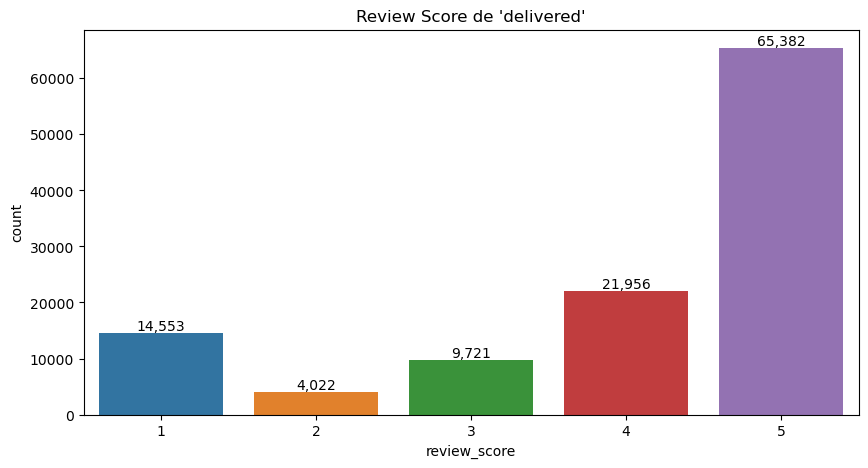

In [17]:
df_score = df_filtrado.review_score.value_counts()
plt.figure(figsize=(10,5))
chart = sns.barplot(x=df_score.index, y=df_score)
chart.set(title="Review Score de 'delivered'")

for i, v in enumerate(df_score.sort_index().values):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')
plt.show()

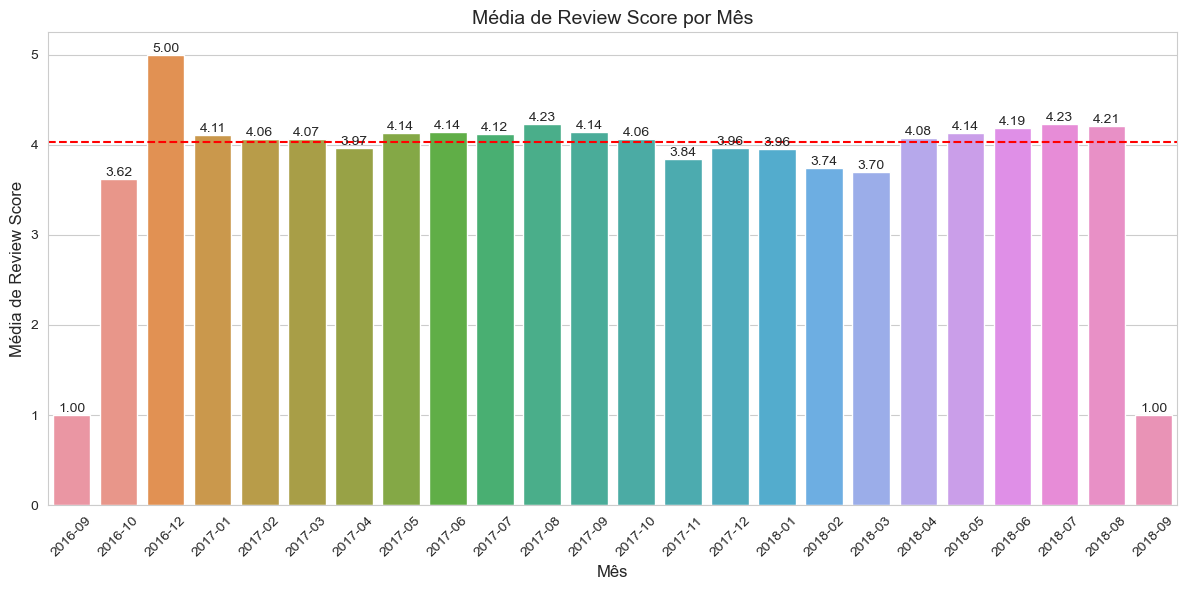

In [18]:
df_pedidos_mes_score = df_filtrado.groupby([df_filtrado['purchase_year_month']]).agg({'review_score':'mean'}).reset_index()
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(x=df_pedidos_mes_score.purchase_year_month, y=df_pedidos_mes_score.review_score)

# Customizando o gráfico
plt.title('Média de Review Score por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Média de Review Score', fontsize=12)
plt.axhline(y=media_score, color='r', linestyle='--')

# Adicionando os valores sobre as barras
for i, v in enumerate(df_pedidos_mes_score.review_score):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Ajustando o layout
plt.xticks(rotation=45)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

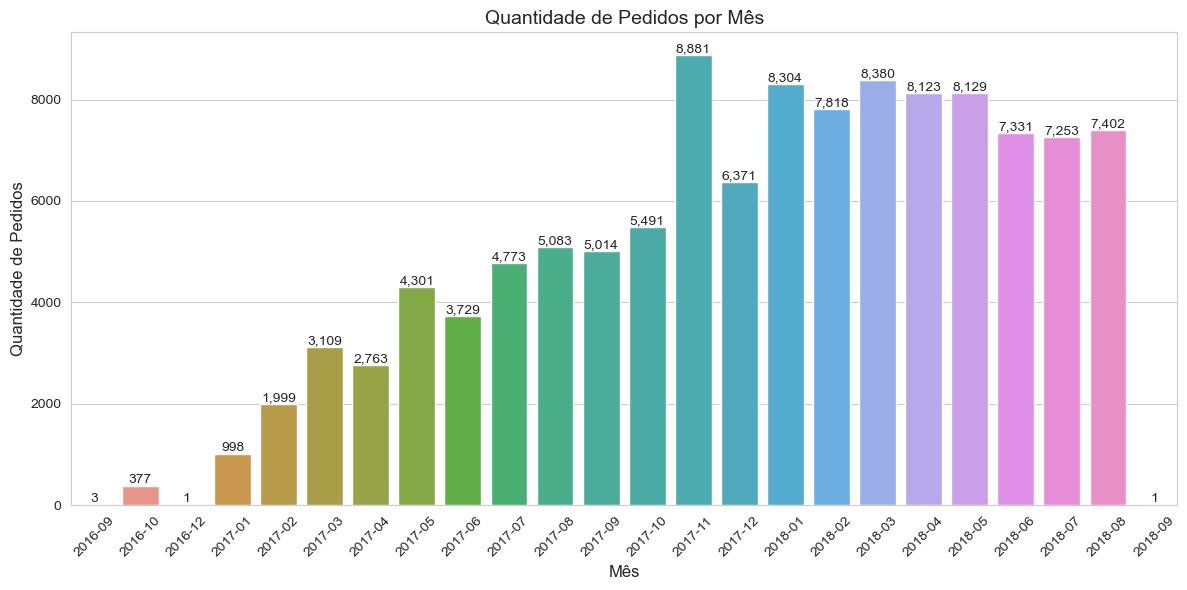

In [19]:
df_pedidos_mes = df_filtrado.groupby([df_filtrado['purchase_year_month']]).size().reset_index(name='total_orders')
# Configurando o estilo
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.barplot(x=df_pedidos_mes.purchase_year_month, y=df_pedidos_mes.total_orders)

# Customizando o gráfico
plt.title('Quantidade de Pedidos por Mês', fontsize=14)
plt.xlabel('Mês', fontsize=12)
plt.ylabel('Quantidade de Pedidos', fontsize=12)


# Adicionando os valores sobre as barras
for i, v in enumerate(df_pedidos_mes.total_orders):
    plt.text(i, v, f'{int(v):,}', ha='center', va='bottom')

# Ajustando o layout
plt.xticks(rotation=45)
plt.tight_layout()

# Exibindo o gráfico
plt.show()

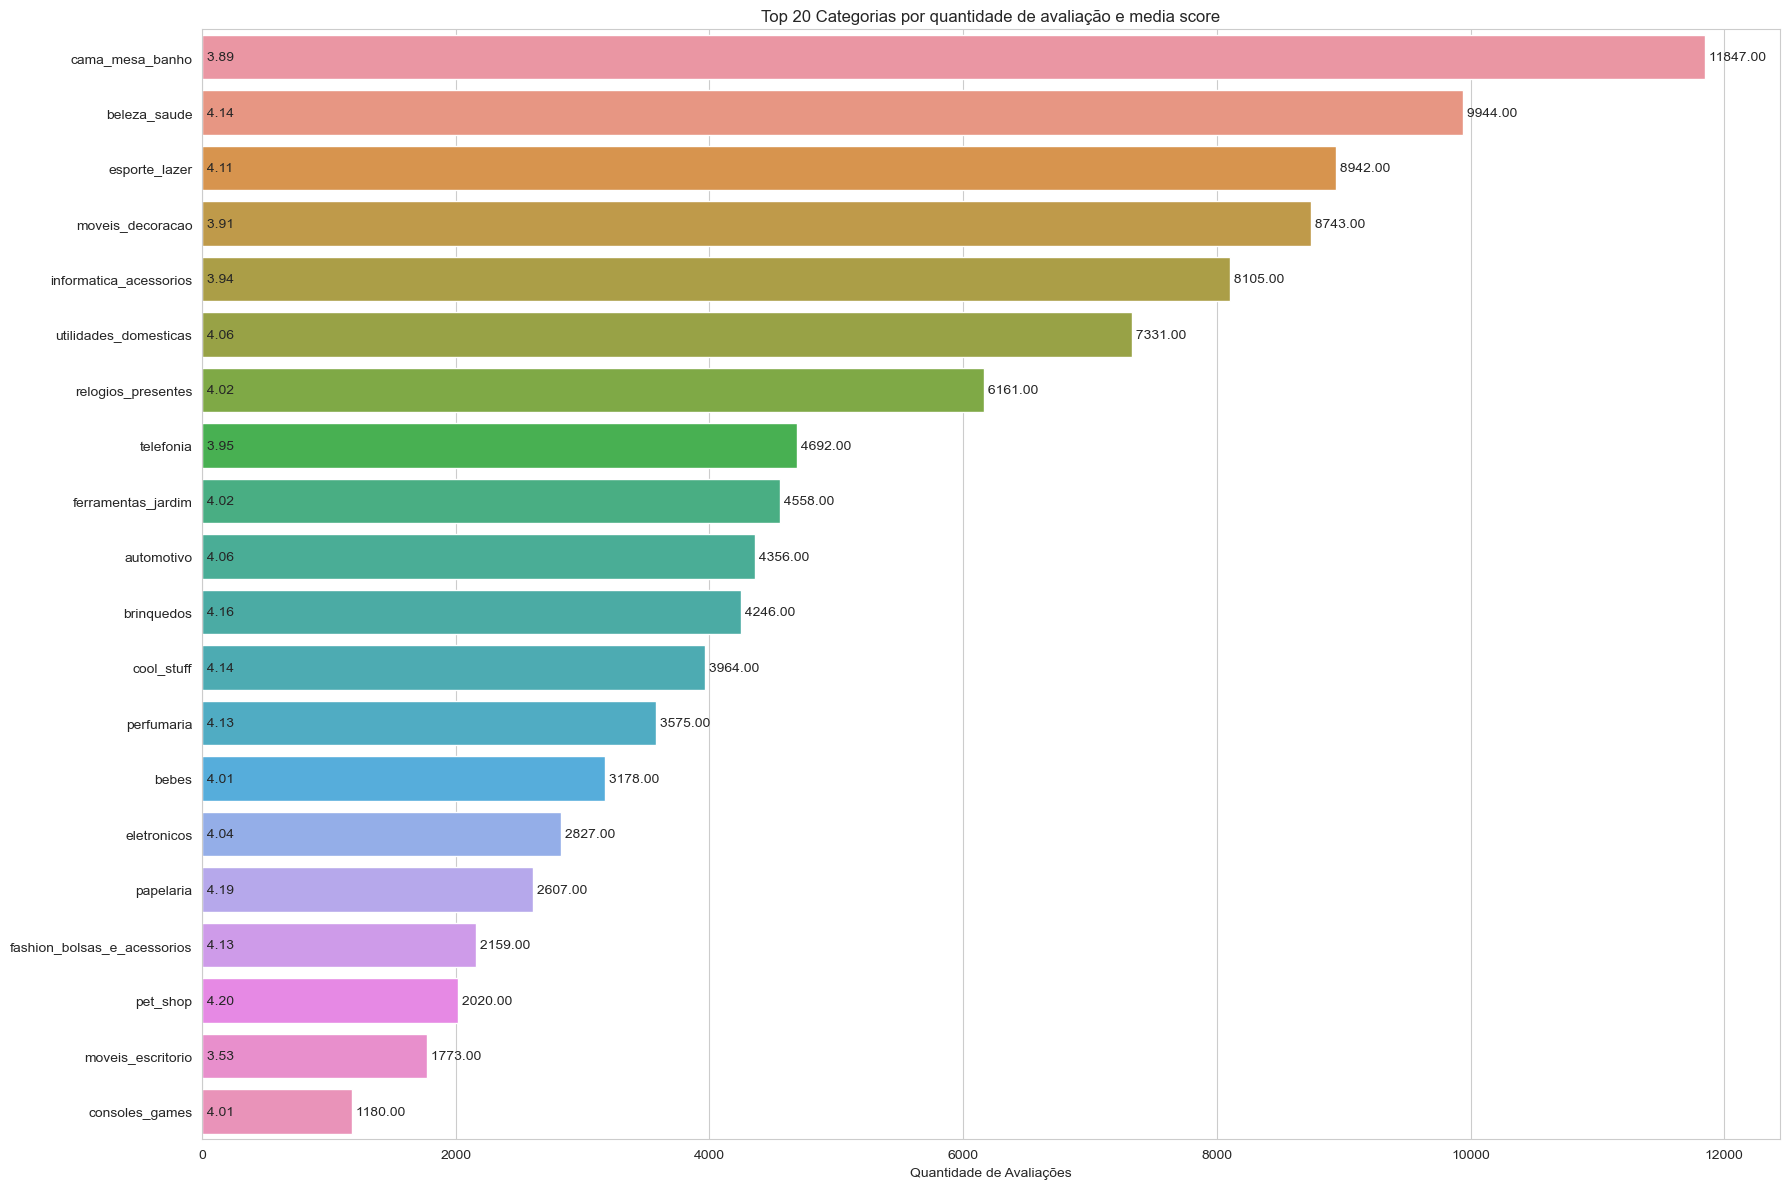

In [20]:
# Group categories by review scores and get mean score
category_scores = df_filtrado.groupby('product_category_name')['review_score'].agg(['mean', 'count']).round(2)
category_scores = category_scores.sort_values('count', ascending=False)

# Plot top 20 categories by average score
plt.figure(figsize=(18, 12))
sns.barplot(data=category_scores.head(20), x='count', y=category_scores.head(20).index)
plt.title('Top 20 Categorias por quantidade de avaliação e media score')
plt.xlabel('Quantidade de Avaliações')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['count']):
    plt.text(v, i, f' {v:.2f}', va='center')
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')
plt.tight_layout()
plt.show()



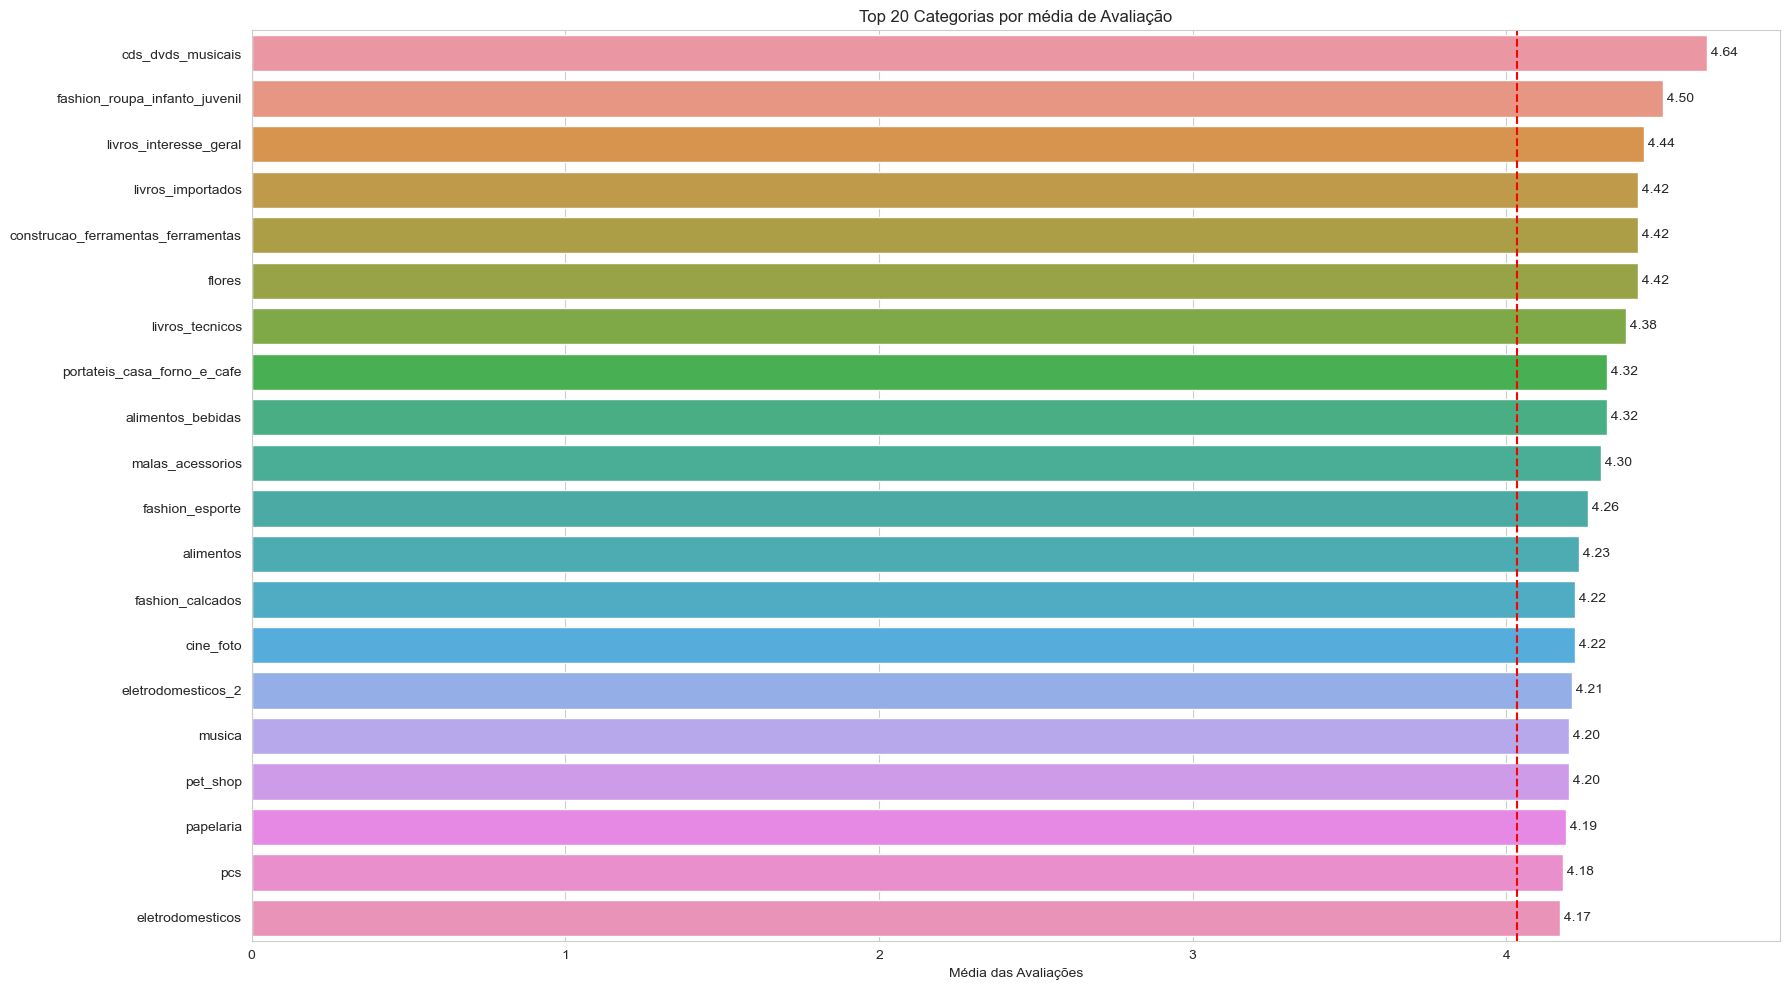

In [21]:
category_scores = category_scores.sort_values('mean', ascending=False)
# Plot top 20 categories by average score
plt.figure(figsize=(18, 10))
sns.barplot(data=category_scores.head(20), x='mean', y=category_scores.head(20).index)
plt.title('Top 20 Categorias por média de Avaliação')
plt.xlabel('Média das Avaliações')
plt.axvline(x=media_score, color='r', linestyle='--')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

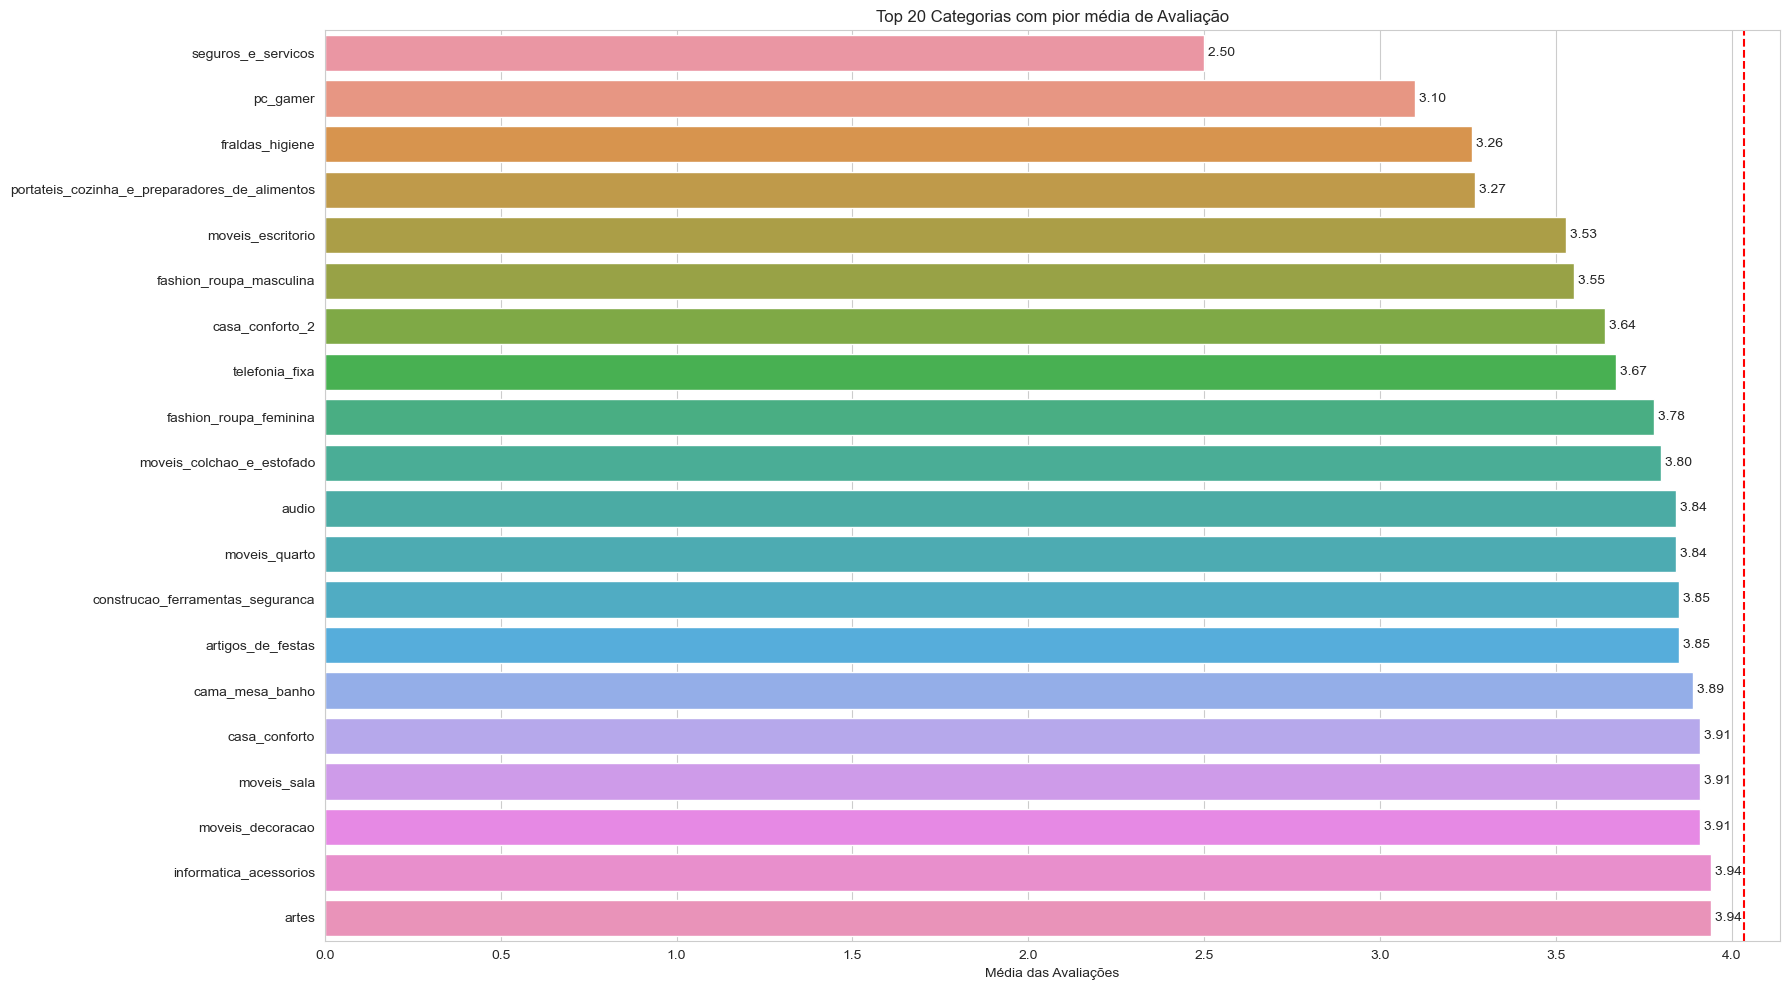

In [22]:
category_scores = category_scores.sort_values('mean', ascending=True)
# Plot top 20 categories
plt.figure(figsize=(18, 10))
sns.barplot(data=category_scores.head(20), x='mean', y=category_scores.head(20).index)
plt.title('Top 20 Categorias com pior média de Avaliação')
plt.xlabel('Média das Avaliações')
plt.axvline(x=media_score, color='r', linestyle='--')
plt.ylabel(None)

# Add value labels
for i, v in enumerate(category_scores.head(20)['mean']):
    plt.text(v, i, f' {v:.2f}', va='center')

plt.tight_layout()
plt.show()

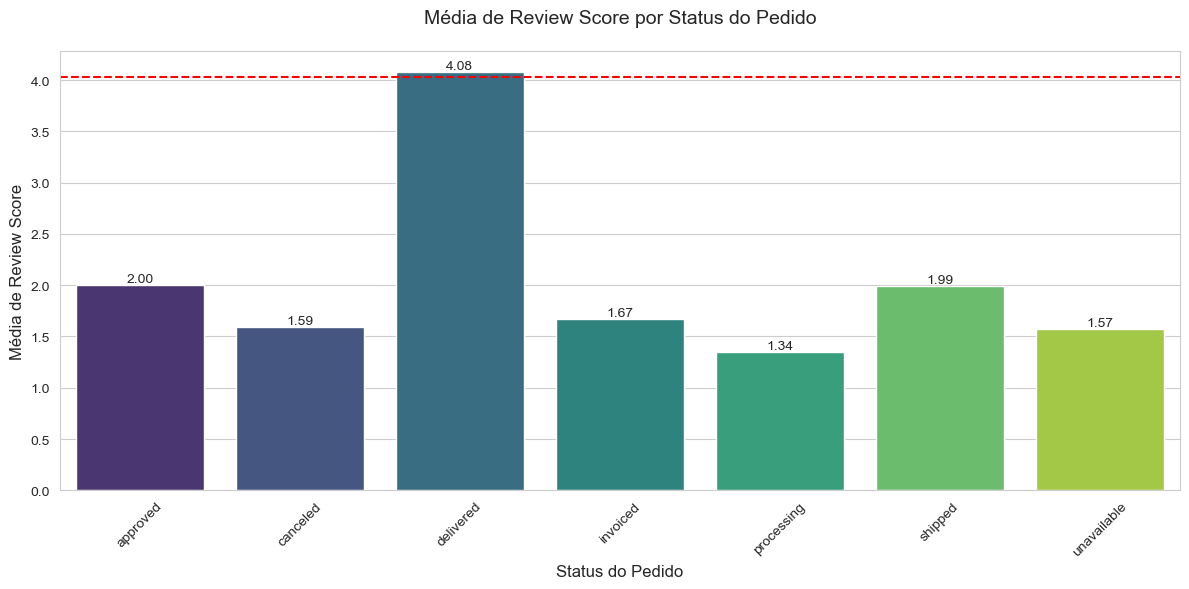

In [23]:
# Calcula a média de review_score por order_status
avg_scores = df_filtrado.groupby('order_status')['review_score'].mean()

# Cria o plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=avg_scores.index, y=avg_scores.values, palette='viridis')

# Customiza o plot
plt.title('Média de Review Score por Status do Pedido', fontsize=14, pad=20)
plt.xlabel('Status do Pedido', fontsize=12)
plt.ylabel('Média de Review Score', fontsize=12)
plt.axhline(y=media_score, color='r', linestyle='--')

# Rotaciona labels do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Adiciona valores nas barras
for i, v in enumerate(avg_scores.values):
    ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# Ajusta layout
plt.tight_layout()

# Mostra o plot
plt.show()

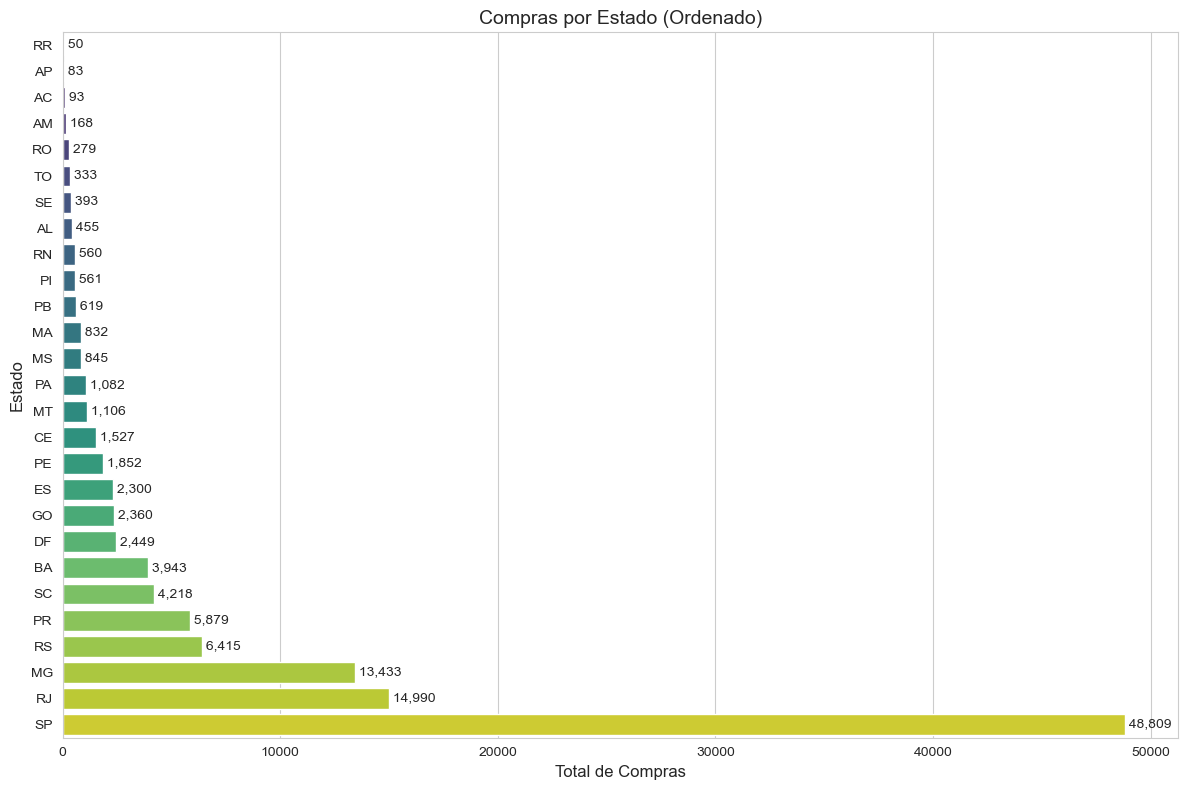

In [24]:
# Criar gráfico de barras horizontal
plt.figure(figsize=(12, 8))

# Preparar dados ordenados
df_groupby = df_filtrado.groupby('customer_state').size().sort_values(ascending=True).reset_index(name='quantidade')

# Criar o gráfico
sns.barplot(data=df_groupby,
            y='customer_state',
            x='quantidade',
            palette='viridis')

# Customizar o gráfico
plt.title('Compras por Estado (Ordenado)', fontsize=14)
plt.xlabel('Total de Compras', fontsize=12)
plt.ylabel('Estado', fontsize=12)

# Adicionar valores nas barras
for i, v in enumerate(df_groupby['quantidade']):
    plt.text(v, i, f' {int(v):,}', va='center')

plt.tight_layout()
plt.show()

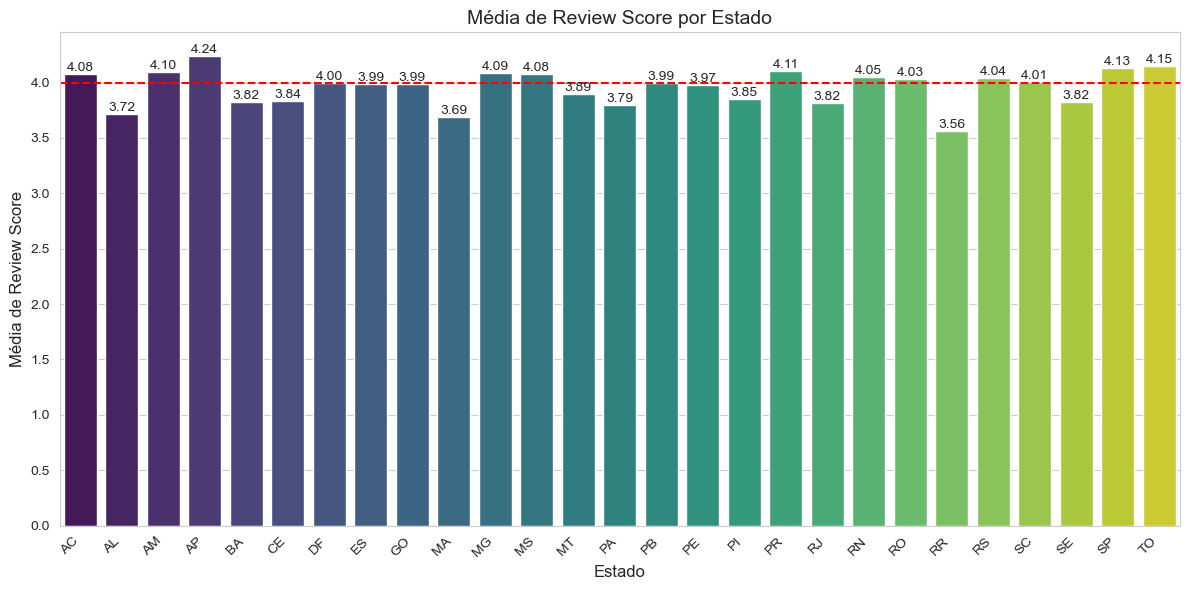

In [25]:
df_state_review = df_filtrado.groupby('customer_state')['review_score'].mean().reset_index()
# Criar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', 
            y='review_score', 
            data=df_state_review,
            palette='viridis')

# Customizar o gráfico
plt.title('Média de Review Score por Estado', fontsize=14)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Média de Review Score', fontsize=12)
plt.axhline(y=4.0, color='r', linestyle='--')

# Rotacionar labels do eixo x
plt.xticks(rotation=45, ha='right')

# Adicionar valores nas barras
for i, v in enumerate(df_state_review['review_score']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

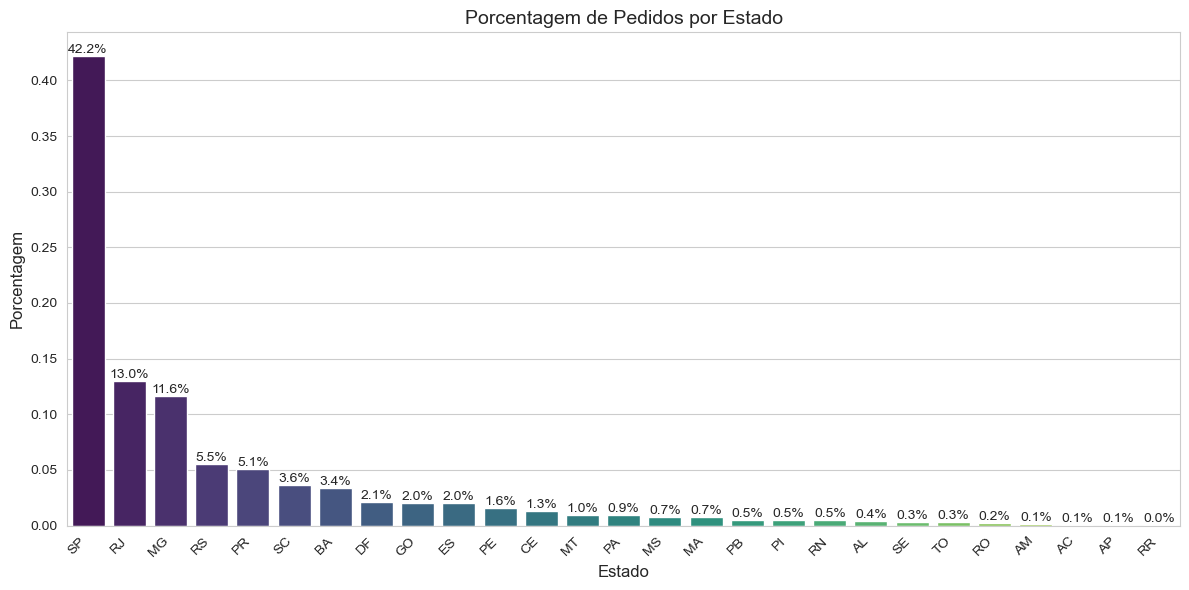

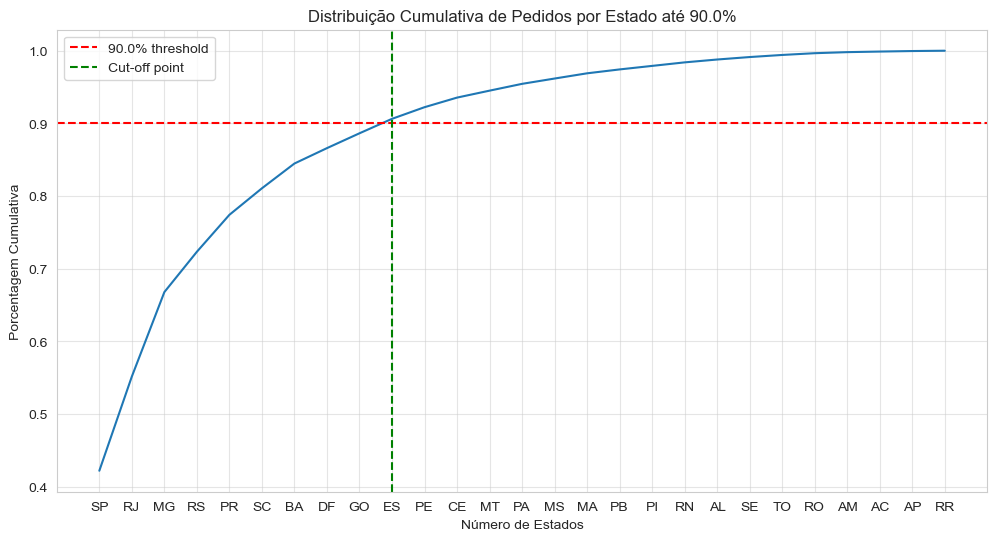

Número de estados do Brasil que representam 90.0% das vendas: 9
['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'DF', 'GO']


In [26]:
df_sorted = df_groupby.sort_values(by='quantidade', ascending=False)
df_sorted['porcentagem_amount'] = df_sorted['quantidade'] / df_sorted['quantidade'].sum()
df_sorted['cumulative_percentage'] = df_sorted['porcentagem_amount'].cumsum()

df_sorted = df_sorted.reset_index()
# Criar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='customer_state', 
            y='porcentagem_amount', 
            data=df_sorted,
            palette='viridis')

# Customizar o gráfico
plt.title('Porcentagem de Pedidos por Estado', fontsize=14)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Porcentagem', fontsize=12)

# Rotacionar labels do eixo x
plt.xticks(rotation=45, ha='right')

# Adicionar valores nas barras
for i, v in enumerate(df_sorted['porcentagem_amount']):
    plt.text(i, v, f'{v:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


porcentagem = 0.9
cities_80_percent = df_sorted[df_sorted['cumulative_percentage'] <= porcentagem].reset_index()

# Optional: Create visualization
plt.figure(figsize=(12, 6))
plt.plot(df_sorted['customer_state'], df_sorted['cumulative_percentage'])
plt.axhline(y=porcentagem, color='r', linestyle='--', label=f'{porcentagem*100}% threshold')
plt.axvline(x=len(cities_80_percent), color='g', linestyle='--', label='Cut-off point')
plt.title(f'Distribuição Cumulativa de Pedidos por Estado até {porcentagem*100}%')
plt.xlabel('Número de Estados')
plt.ylabel('Porcentagem Cumulativa')
plt.legend()
plt.grid(True,alpha=0.5)
plt.show()
print(f'Número de estados do Brasil que representam {porcentagem*100}% das vendas: {len(cities_80_percent)}')
print(list(cities_80_percent.customer_state))

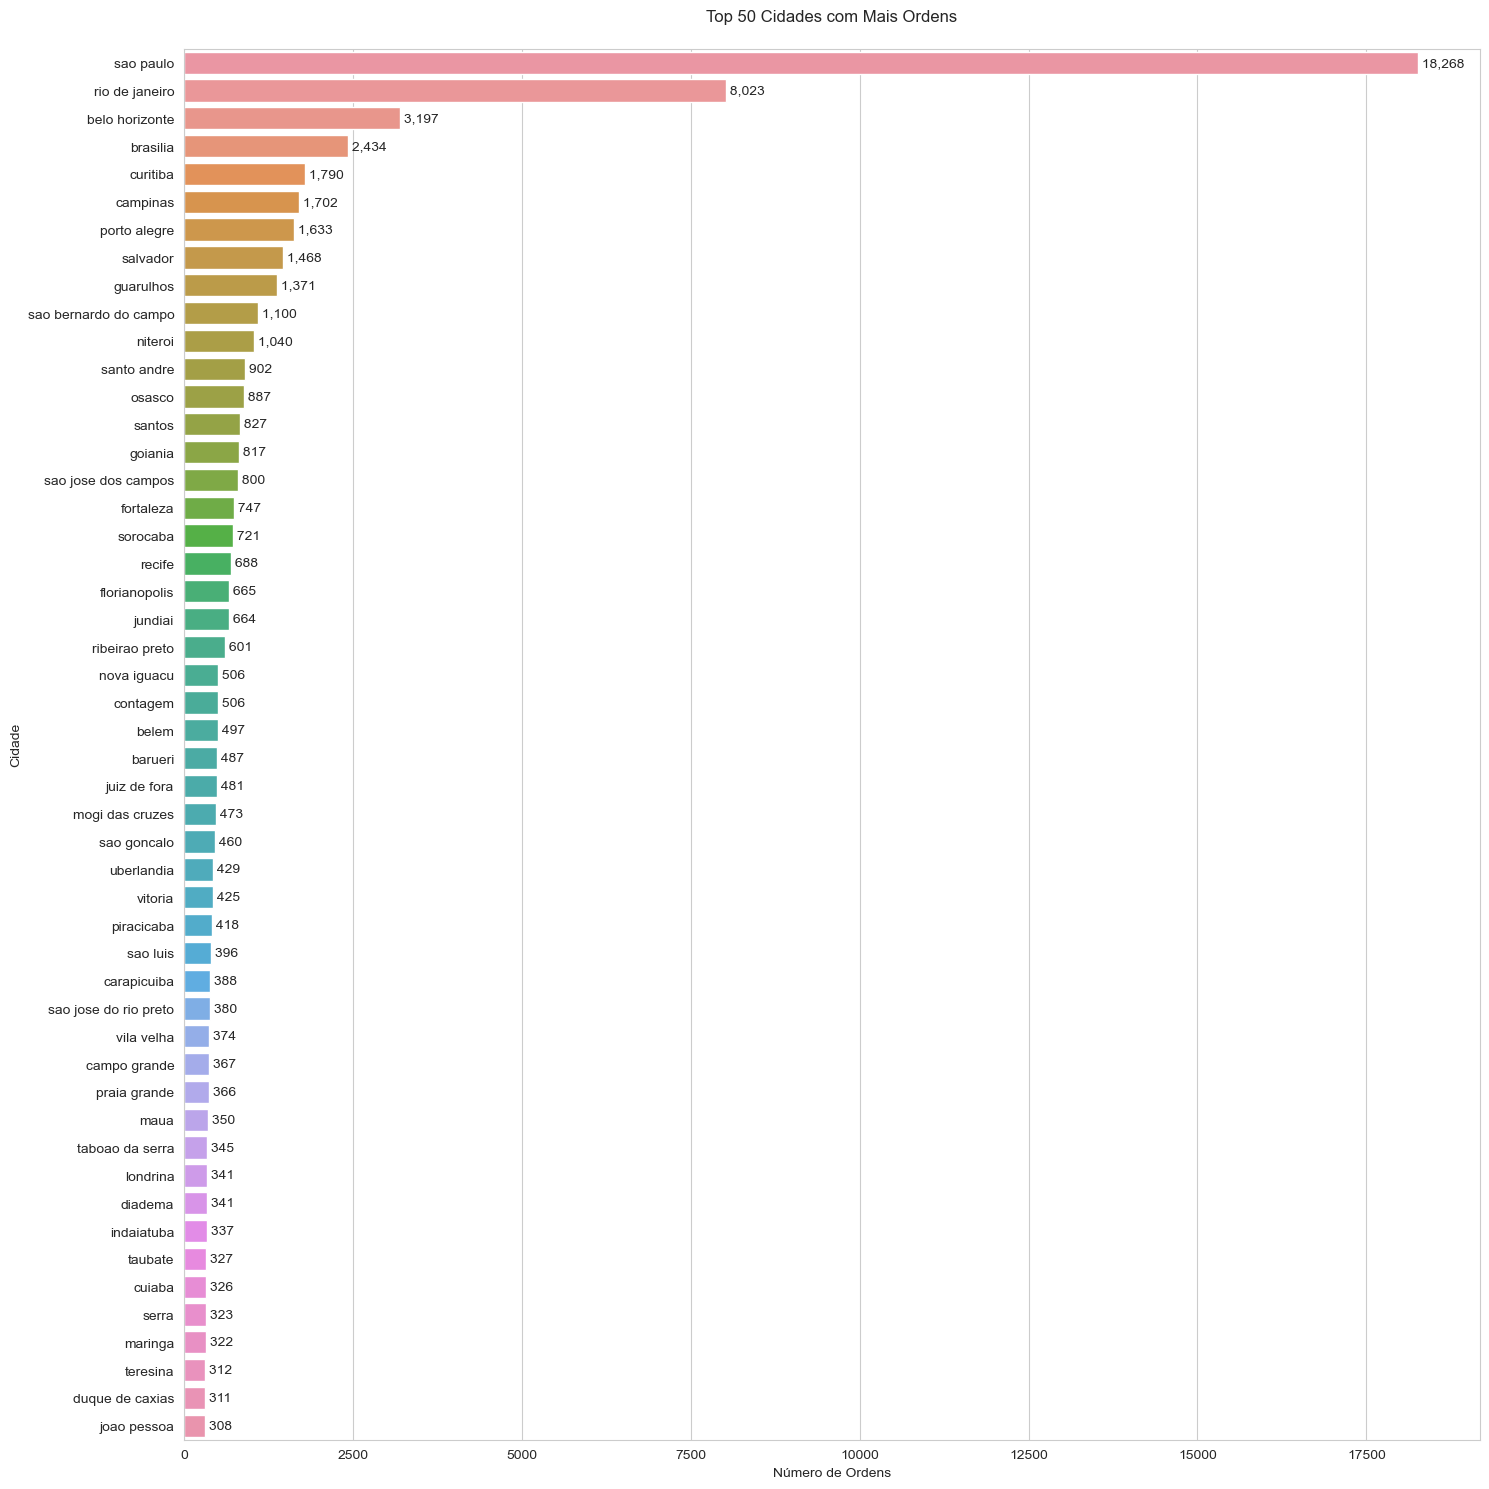

In [27]:
# Get top 50 cities for better visualization
top_cities = df_filtrado.customer_city.value_counts().head(50)

# Create the plot
plt.figure(figsize=(15, 15))
sns.barplot(x=top_cities.values, y=top_cities.index)

# Customize the plot
plt.title('Top 50 Cidades com Mais Ordens', pad=20)
plt.xlabel('Número de Ordens')
plt.ylabel('Cidade')

# Add value labels on bars
for i, v in enumerate(top_cities.values):
    plt.text(v, i, f' {v:,}', va='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

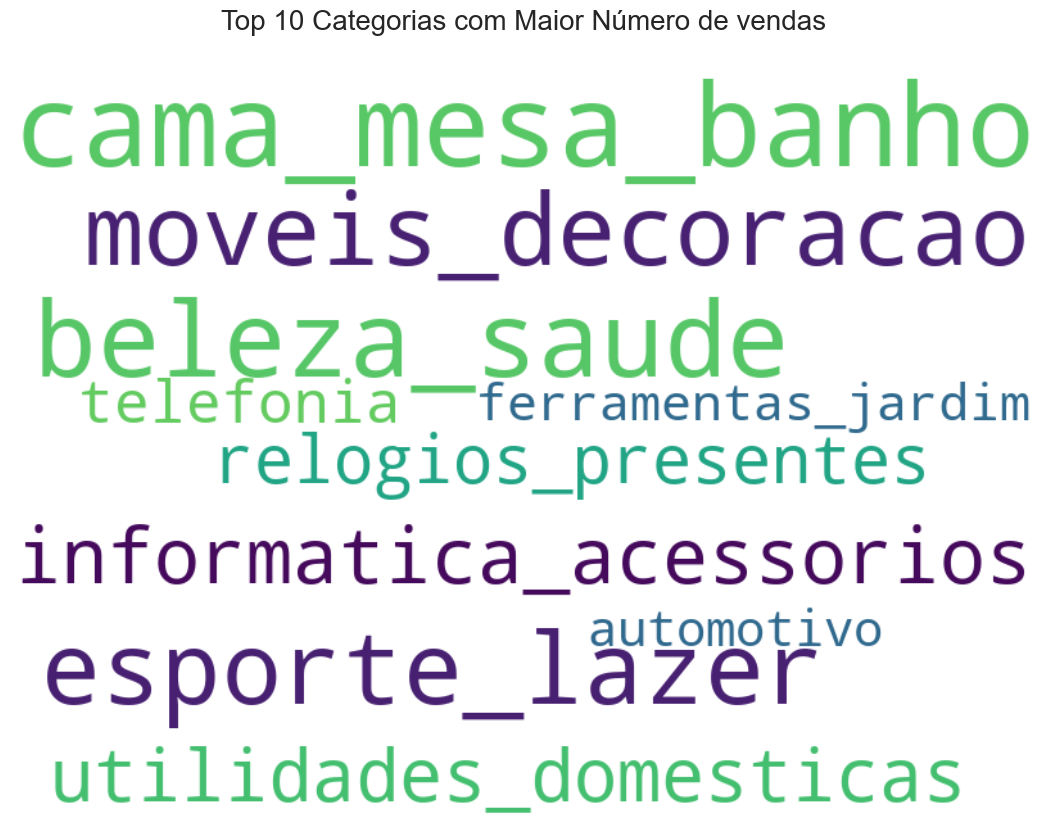

In [28]:
# Create dictionary for wordcloud
word_dict = dict(df_filtrado.product_category_name.value_counts().head(10))

# Configure and create WordCloud
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    colormap='viridis',  # You can try other colormaps like 'plasma', 'magma', 'YlOrRd','viridis'
    min_font_size=10,
    max_font_size=200,
    random_state=42
).generate_from_frequencies(word_dict)

# Create plot
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 10 Categorias com Maior Número de vendas', 
          fontsize=20, 
          pad=20)

# Show plot
plt.show()

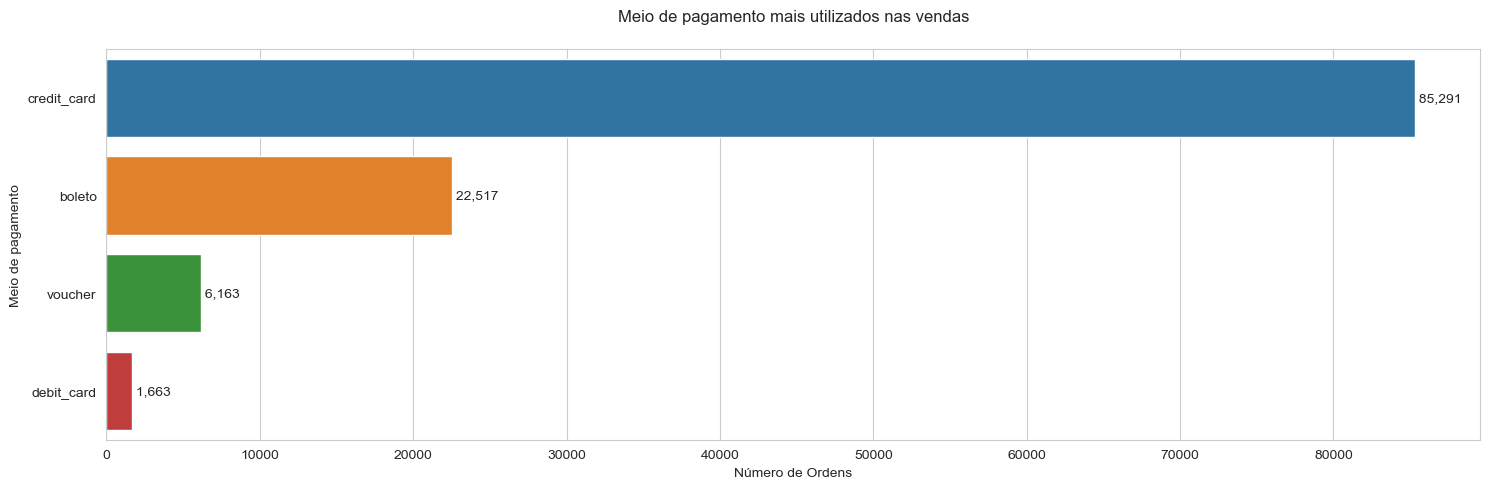

In [29]:
# Get top 50 cities for better visualization
tipo_pagamento = df_filtrado.payment_type.value_counts()

# Create the plot
plt.figure(figsize=(15, 5))
sns.barplot(x=tipo_pagamento.values, y=tipo_pagamento.index)

# Customize the plot
plt.title('Meio de pagamento mais utilizados nas vendas', pad=20)
plt.xlabel('Número de Ordens')
plt.ylabel('Meio de pagamento')

# Add value labels on bars
for i, v in enumerate(tipo_pagamento.values):
    plt.text(v, i, f' {v:,}', va='center')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

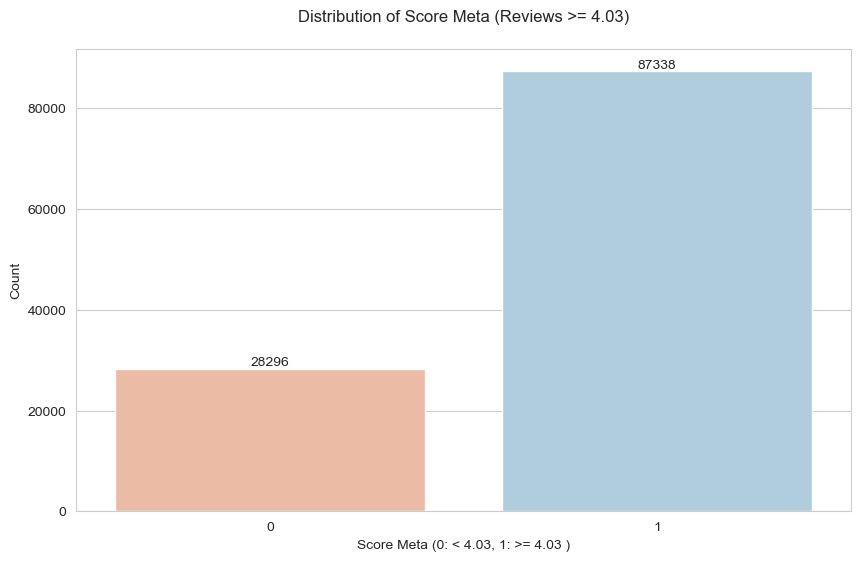

In [53]:
#ETAPA FINAL ANTES DO MODELO

# Create score_meta column
df_filtrado['score_meta'] = (df_filtrado.review_score >= 4).astype(int)

# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtrado, x='score_meta', palette='RdBu')

# Add value labels on top of bars
for i in plt.gca().containers:
    plt.gca().bar_label(i)

# Customize the plot
plt.title(f'Distribution of Score Meta (Reviews >= {media_score:.2f})', pad=20)
plt.xlabel(f'Score Meta (0: < {media_score:.2f}, 1: >= {media_score:.2f} )')
plt.ylabel('Count')

# Show plot
plt.show()

In [ ]:
df_filtrado = df_filtrado.drop(columns=['review_score','customer_city','seller_city','purchase_year_month'])
# df_filtrado =df_filtrado.drop(columns=['order_status'])

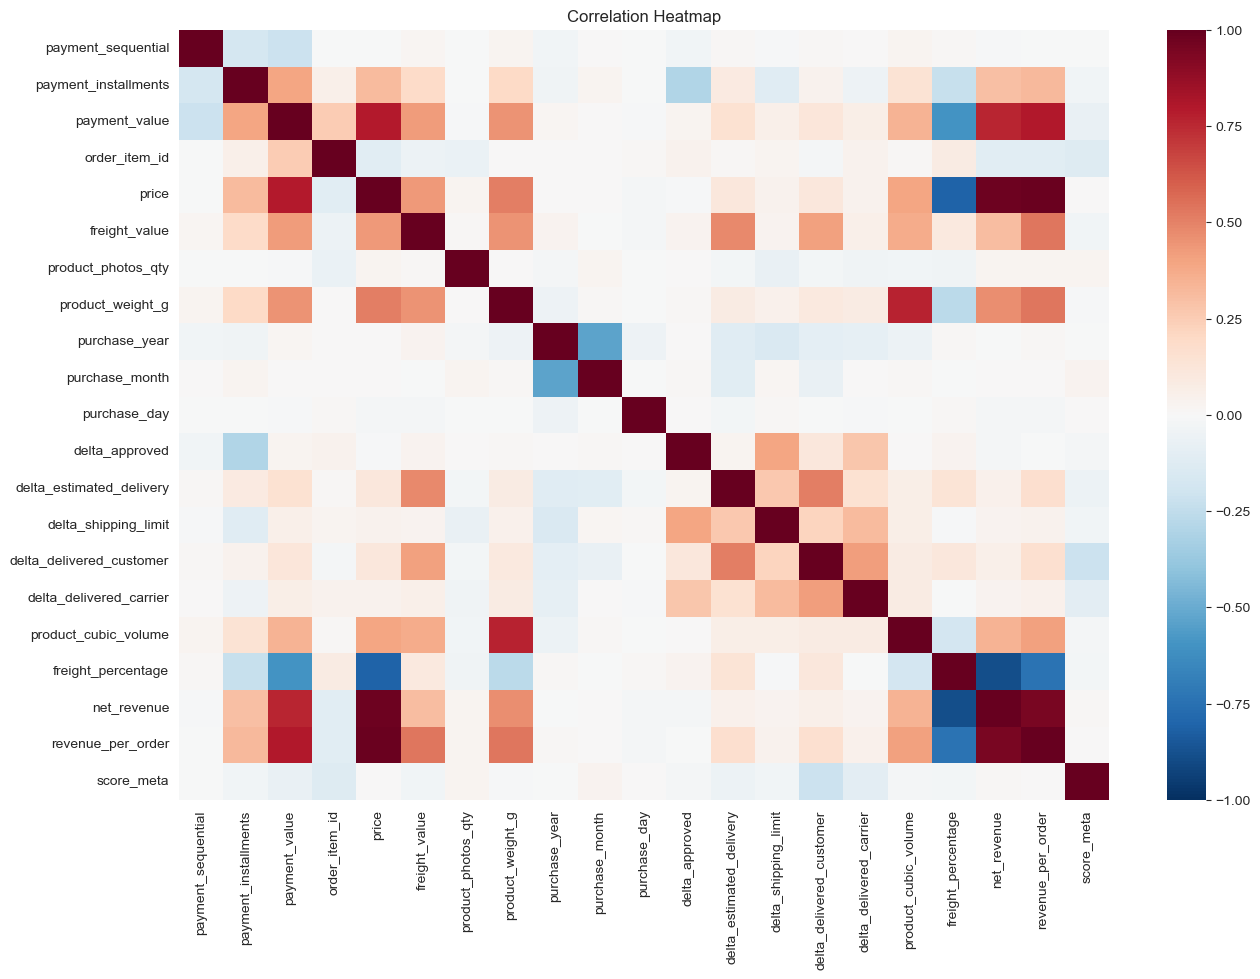

In [65]:
#ai sim fazer o heatmap
reduzida_corr = df_filtrado.select_dtypes(include=['number']).corr(method='spearman')
plt.figure(figsize=(15, 10))
sns.heatmap(reduzida_corr, cmap='RdBu_r', norm=plt.Normalize(-1,1))
plt.title("Correlation Heatmap")
plt.show()

In [66]:
data_info(df_filtrado)

Dataset Shape: (115634, 26)


,dtypes,Missing,Unique,Example,Entropy
payment_sequential,int64,0,29,1,0.34
payment_type,object,0,4,credit_card,1.10
payment_installments,int64,0,24,1,2.47
payment_value,float64,0,28664,18.12,13.96
customer_state,object,0,27,SP,3.07
order_item_id,int64,0,21,1,0.72
price,float64,0,5882,29.99,9.57
freight_value,float64,0,6954,8.72,10.51
product_category_name,object,0,73,utilidades_domesticas,4.71
product_photos_qty,float64,0,19,4.0,2.17


In [105]:
df_filtrado_dummy = pd.get_dummies(df_filtrado, drop_first=False)
bool_columns = df_filtrado_dummy.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df_filtrado_dummy[col] = df_filtrado_dummy[col].astype(int)

df_filtrado_dummy.shape,df_filtrado.shape

((115634, 149), (115634, 26))

# Pré-processamento


In [106]:
## base
X = df_filtrado_dummy.drop(columns=['score_meta'])
y = df_filtrado_dummy['score_meta']
X.head()


,payment_sequential,payment_installments,payment_value,order_item_id,price,freight_value,product_photos_qty,product_weight_g,purchase_year,purchase_month,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,1,1,18.12,1,29.99,8.72,4.0,500.0,2017,10,...,0,0,0,0,0,0,0,0,0,1
1,3,1,2.00,1,29.99,8.72,4.0,500.0,2017,10,...,0,0,0,0,0,0,0,0,0,1
2,2,1,18.59,1,29.99,8.72,4.0,500.0,2017,10,...,0,0,0,0,0,0,0,0,0,1
3,1,3,37.77,1,29.99,7.78,4.0,500.0,2017,8,...,0,0,0,0,0,0,0,0,0,1
4,1,1,37.77,1,29.99,7.78,4.0,500.0,2017,8,...,0,0,0,0,0,0,0,0,0,1


# pré-processamento e modelos

## Transformer para Tratamento de Outliers

Este código implementa um transformer personalizado para tratamento de outliers usando o método do Intervalo Interquartil (IQR). 

### Funcionamento

1. **Inicialização**: 
   - Cria variáveis para armazenar Q1 (primeiro quartil), Q3 (terceiro quartil) e IQR (intervalo interquartil)

2. **Método Fit**:
   - Calcula Q1 (25º percentil)
   - Calcula Q3 (75º percentil)
   - Calcula IQR (Q3 - Q1)

3. **Método Transform**:
   - Calcula limites para outliers usando a fórmula:
     - Limite inferior = Q1 - 1.5 * IQR
     - Limite superior = Q3 + 1.5 * IQR
   - Aplica os limites aos dados usando clip()

### Uso
Este transformer pode ser usado em pipelines do scikit-learn para tratar automaticamente outliers nos dados durante o pré-processamento.

### Vantagens
- Método robusto e não paramétrico
- Preserva a distribuição dos dados dentro dos limites aceitáveis
- Compatível com scikit-learn

In [153]:
# Custom transformer para tratamento de outliers usando o método IQR (Intervalo Interquartil)
class OutlierTreatment(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Inicializa as variáveis que armazenarão os quartis e o IQR
        self.Q1 = None  # Primeiro quartil (25%)
        self.Q3 = None  # Terceiro quartil (75%)
        self.IQR = None # Intervalo interquartil (Q3 - Q1)
        
    def fit(self, X, y=None):
        # Calcula os quartis e o IQR durante o fitting
        self.Q1 = X.quantile(0.25)  # Calcula o primeiro quartil
        self.Q3 = X.quantile(0.75)  # Calcula o terceiro quartil
        self.IQR = self.Q3 - self.Q1 # Calcula o intervalo interquartil
        return self
    
    def transform(self, X):
        # Calcula os limites inferior e superior para identificação de outliers
        lower = self.Q1 - 1.5 * self.IQR  # Limite inferior = Q1 - 1.5 * IQR
        upper = self.Q3 + 1.5 * self.IQR  # Limite superior = Q3 + 1.5 * IQR
        # Aplica os limites aos dados, substituindo valores extremos
        return X.clip(lower=lower, upper=upper, axis=1)

## Divisão dos Dados em Treino e Teste

A divisão dos dados é uma etapa crucial no processo de machine learning:

### Parâmetros Utilizados
- **test_size=0.2**: 
  - 20% dos dados são separados para teste
  - 80% dos dados são mantidos para treino
  - Esta proporção é comum na prática e oferece um bom equilíbrio

- **random_state=42**: 
  - Garante que a divisão seja reproduzível
  - Mesmo resultado cada vez que o código é executado
  - Importante para comparação de diferentes modelos


In [154]:
# Divide os dados em conjuntos de treino e teste
# X: features (variáveis independentes)
# y: target (variável dependente/alvo)
# test_size=0.2: 20% dos dados para teste, 80% para treino
# random_state=42: garante reprodutibilidade da divisão
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Configuração dos Modelos de Machine Learning

Este código configura quatro modelos diferentes de machine learning para comparação:

### Características Comuns
- Todos os modelos usam a mesma semente aleatória (42) para reprodutibilidade
- Paralelização habilitada em todos (`n_jobs=-1` ou `thread_count=-1`)
- Modo silencioso ativado para execução limpa
- Ranges de hiperparâmetros específicos para cada modelo

### Modelos Implementados

1. **Random Forest**
   - Ensemble de árvores de decisão
   - 100-300 árvores
   - Profundidade máxima: 10-40

2. **XGBoost**
   - Gradient boosting otimizado
   - Usa logloss como métrica
   - Profundidade máxima: 3-40

3. **LightGBM**
   - Implementação eficiente da Microsoft
   - Otimizado para grandes datasets
   - Profundidade máxima: 6-40

4. **CatBoost**
   - Especializado em features categóricas
   - Profundidade menor (4-12) devido à sensibilidade
   - Melhor tratamento automático de categorias

### Estrutura
- Cada modelo é configurado em um dicionário
- Parâmetros separados em 'model' (instância) e 'params' (para otimização)
- Prefixo 'model__' necessário para uso em Pipeline

In [108]:
# Define uma semente aleatória para reprodutibilidade
seed = 42

# Dicionário com configurações dos modelos de machine learning
models = {
    # Random Forest: Modelo baseado em múltiplas árvores de decisão
    "RandomForest": {
        'model': RandomForestClassifier(
            random_state=seed,  # Garante reprodutibilidade
            n_jobs=-1,         # Usa todas as CPUs disponíveis
            verbose=0          # Modo silencioso
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de árvores
            'model__max_depth': Integer(10, 40)        # Profundidade máxima
        }
    },
    
    # XGBoost: Implementação otimizada de Gradient Boosting
    "XGBoost": {
        'model': XGBClassifier(
            use_label_encoder=False,  # Desativa codificador de rótulos legado
            eval_metric="logloss",    # Métrica de avaliação
            random_state=seed,        # Reprodutibilidade
            n_jobs=-1,               # Paralelização
            verbose=0                # Modo silencioso
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de boosting rounds
            'model__max_depth': Integer(3, 40)         # Profundidade máxima
        }
    },
    
    # LightGBM: Implementação eficiente de Gradient Boosting da Microsoft
    "LightGBM": {
        'model': LGBMClassifier(
            random_state=seed,  # Reprodutibilidade
            verbose=-1,        # Modo silencioso
            n_jobs=-1         # Paralelização
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de boosting rounds
            'model__max_depth': Integer(6, 40)         # Profundidade máxima
        }
    },
    
    # CatBoost: Especializado em variáveis categóricas
    "CatBoost": {
        'model': CatBoostClassifier(
            verbose=0,          # Modo silencioso
            random_state=seed,  # Reprodutibilidade
            thread_count=-1     # Usa todas as threads
        ),
        'params': {
            'model__n_estimators': Integer(100, 300),  # Número de árvores
            'model__depth': Integer(4, 12)             # Profundidade (menor range devido à sensibilidade)
        }
    }
}

## Treinamento e Avaliação de Modelos

Este código implementa um pipeline completo de machine learning para comparar diferentes modelos:

### Pipeline de Processamento
1. **Tratamento de Outliers**: Usa método IQR para lidar com valores extremos
2. **Normalização**: StandardScaler para padronizar as features
3. **Redução de Dimensionalidade**: PCA com 10 componentes
4. **Modelo**: Algoritmo de ML específico

### Otimização de Hiperparâmetros
- Usa **Busca Bayesiana** (BayesSearchCV)
- 32 iterações de busca
- Validação cruzada com 3 folds
- Otimiza para maximizar acurácia
- Paralelização ativada (exceto para CatBoost)

### Avaliação
- Treina cada modelo com os melhores parâmetros encontrados
- Faz previsões no conjunto de teste
- Calcula acurácia das previsões
- Armazena resultados em DataFrame com:
  - Nome do modelo
  - Profundidade máxima (max_depth)
  - Número de estimadores
  - Acurácia alcançada

### Resultados
- DataFrame final ordenado por acurácia
- Permite comparação direta entre modelos
- Facilita identificação do melhor modelo

In [113]:


# Lista para armazenar resultados de cada modelo
results = []

# Itera sobre cada modelo definido no dicionário 'models'
for name, model_info in models.items():   
    # Define pipeline de processamento e modelagem
    pipeline = Pipeline([
        ('outlier', OutlierTreatment()),          # Tratamento de outliers
        ('scaler', StandardScaler().set_output(transform="pandas")),  # Normalização
        ('pca', PCA(n_components=10)),            # Redução de dimensionalidade
        ('model', model_info['model'])            # Modelo de ML
    ])

    # Configura busca Bayesiana de hiperparâmetros
    bayes_search = BayesSearchCV(
        pipeline,                                 # Pipeline a ser otimizado
        model_info['params'],                     # Espaço de parâmetros
        cv=3,                                     # Validação cruzada com 3 folds
        n_iter=32,                               # Número de iterações
        scoring='accuracy',                       # Métrica de avaliação
        n_jobs=-1 if name != "CatBoost" else 1,  # Paralelização (exceto CatBoost)
        random_state= seed                         # Semente aleatória para reprodutibilidade
    )
    
    # Treina o modelo com busca de hiperparâmetros
    bayes_search.fit(X_train, y_train)

    # Faz previsões e calcula acurácia
    y_pred = bayes_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Armazena resultados do modelo
    results.append({
        "Modelo": name, 
        "Depth": bayes_search.best_params_['model__depth'] if name == "CatBoost" else bayes_search.best_params_['model__max_depth'],
        "N Estimators": bayes_search.best_params_['model__n_estimators'],
        "Acurácia": accuracy
    })
    bayes_search

# Converte resultados para DataFrame
df_results = pd.DataFrame(results)

df_results.to_csv('output/model_results3.csv', index=False, encoding='utf-8')
# Ordena modelos por acurácia (melhor primeiro)
df_results.sort_values(by='Acurácia', ascending=False)


,Modelo,Depth,N Estimators,Acurácia
0,RandomForest,32,300,0.815021
1,XGBoost,36,100,0.806676
3,CatBoost,12,300,0.801098
2,LightGBM,40,300,0.773598


In [155]:


N_JOBS = -1
models_config = {
    'RandomForest': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),  
            ('model', RandomForestClassifier(
                n_estimators=300,
                max_depth=32,
                n_jobs=N_JOBS,
                verbose=0,
                random_state=42
            ))
        ])
    },
    'XGBoost': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),
            ('model', XGBClassifier(
                n_estimators=100,
                max_depth=36,
                use_label_encoder=False,
                eval_metric='logloss',
                n_jobs=N_JOBS,
                verbosity=0,
                random_state=42
            ))
        ])
    },
    'LightGBM': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),
            ('model', LGBMClassifier(
                n_estimators=300,
                max_depth=40,
                num_threads=N_JOBS,
                verbose=-1,
                random_state=42
            ))
        ])
    },
    'CatBoost': {
        'pipeline': Pipeline([
            ('iqr', OutlierTreatment()),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=10)),
            ('model', CatBoostClassifier(
                iterations=300,
                depth=12,
                thread_count=N_JOBS,
                verbose=0,
                random_state=42
            ))
        ])
    }
}


results = []
for model_name, config in models_config.items():
    
    pipeline = config['pipeline']
    pipeline.fit(X_train, y_train)
    
    # Previsões e métricas
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append({
        'Modelo': model_name,
        'Acurácia': acc,
        'Matriz': cm
    })  

df_results = pd.DataFrame(results).sort_values('Acurácia', ascending=False)
print("\nResultados Comparativos:")
df_results[['Modelo', 'Acurácia','Matriz']]



Resultados Comparativos:


,Modelo,Acurácia,Matriz
0,RandomForest,0.815021,"[[1656, 3973], [305, 17193]]"
1,XGBoost,0.806676,"[[1972, 3657], [814, 16684]]"
3,CatBoost,0.801098,"[[1851, 3778], [822, 16676]]"
2,LightGBM,0.773598,"[[727, 4902], [334, 17164]]"


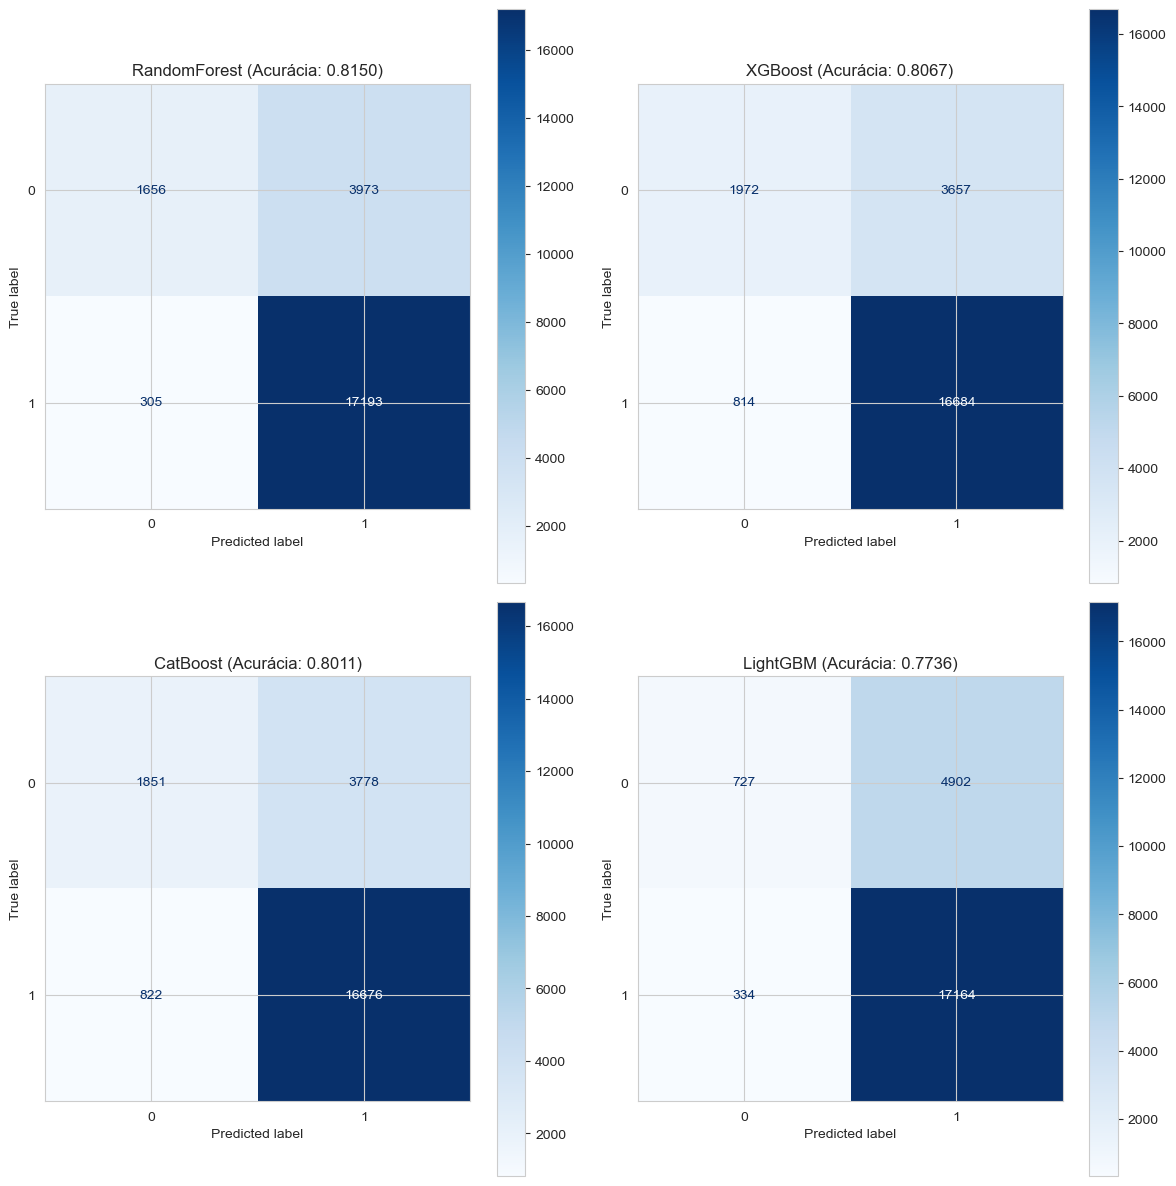

In [156]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()  # Flatten the 2x2 array to make it easier to iterate
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for idx, (index, row) in enumerate(df_results.iterrows()):
    ConfusionMatrixDisplay(row['Matriz']).plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f"{row['Modelo']} (Acurácia: {row['Acurácia']:.4f})")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()